# Baysian A/B testing 
### Bryant Crocker

Code heavily borrowed from: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb

# Problem Definition:

Often in digital marketing and web development we are intested in seeing if a change in a website, app or email produces a meaningful difference in in a key performance indicator like conversion rate.  Conversion rate is the proportion of times a users do a given action, in this case we will choose making a purchase on a website.

It can be difficult to see if a difference is meaningful or if it is more likely due to chance.  This becomes even more difficult when the number of observations in a treatmeant is small.  Making your A/B test baysian helpss one deal with small sample sizes and also allows you to evaluate the probability of both the null and alternative hypothesis. 

In this problem we will assume that we are web developers comparing the conversion rate of two different web page designs.  We think that a new proposed design will work much better.  We want to estimate the proportion that convert and purchase a proudct for each page design and also what difference in conversion rate we can expect for each respective design.  

In this A/B test we only want to show a small proportion of users the new page. We are very unsure how users will percieve that new change and we want to make sure we don't lose too many users if the design is bad.  Becasue of this design A, the old design, will have a much larger sample size that design B, our new experimental UI design.

# Simulating variables 

In [55]:
import pymc3 as pm
from scipy import stats
import matplotlib.pyplot as plt 
import numpy as np
import statistics as stat

#I'll start by defining two true proportions of conversion rate. In reality we wouldn't know this but for example we 
#will assume this is known
true_p_A = 0.085
true_p_B = 0.095

#I'll set two different Ns for our two differnt conversion rate proportions web pages
N_A = 2000
N_B = 135

#generate some sample observations using a benoulli distribution using the defined paramters. 
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)

In the code chunk above, I first import the pymc3 pacakage and then the scipy stats package.  I define true proportions of conversion rate for the two different web pages. Then to simulate data for this experiment I use scipy states to sample from a bernoulli distribution paramterized by my true proportions and sample sizes.  This is just a way to generate dummy data. If sample from teh bernoulli distribution confuses you do not worry too much, this piece isn't super important.

# Define the pymc3 model and sample from the posterior distribution.

In bayesian statisitcs we use prior probabilities and data to infer about a posterior distribution. Prior probabilities are probabiliy distributions that bayesians use to reprsent what we know about the parameters prior to observing data.  In this given problem we need to define two prior probability distributions, one for the conversion ratio of page A and one for the conversion ratio of page B.  We use what is refered to as an uniformative prior for these two probability distributions. By unifomrative, we mean that the distribution is flat, and doesn't give us any information about what the true proportion is. A uniform distribution with between the values 0 and 1 is used as the prior distribution for both proportions.  The prior bounds the posterior distribution to be between 0 and 1 because we know that a proportion must fall between that.

After defiing a prior distribution we use this prior distribution and our observed data to construct a posterior distribution based on bayes thereom. We then use the metropolis hastings algorithm to sample from the posterior distribution to infer the mean difference in conversion rates between the two websites.

In [42]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]
    
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:14<00:00, 5642.11draws/s]
The number of effective samples is smaller than 25% for some parameters.


MAP delta: -0.058249079824816696


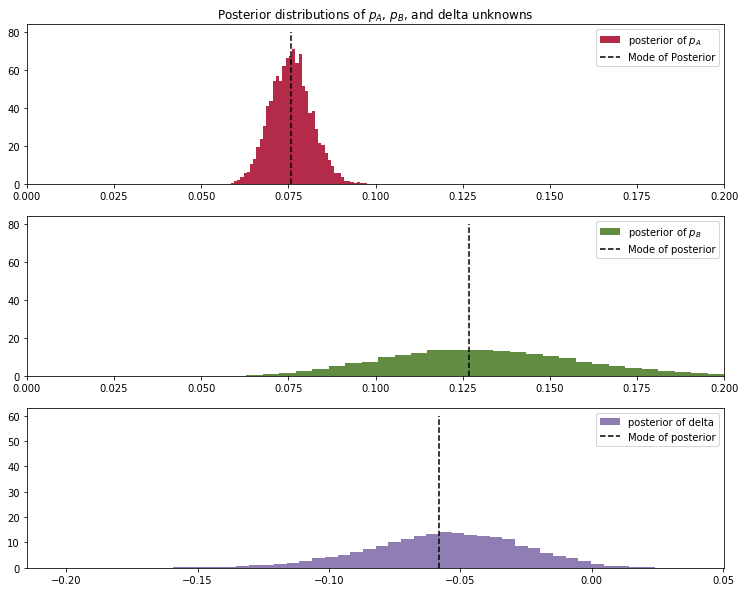

In [65]:
plt.figure(figsize=(12.5, 10))

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .2)
plt.hist(p_A_samples, histtype='stepfilled', bins=50, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(stat.mode(p_A_samples), 0, 80, linestyle="--", label="Mode of Posterior")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .2)
plt.hist(p_B_samples, histtype='stepfilled', bins=50, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(stat.mode(p_B_samples), 0, 80, linestyle="--", label="Mode of posterior")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=50, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(stat.mode(delta_samples), 0, 60, linestyle="--",
           label="Mode of posterior")
plt.legend(loc="upper right");
print("MAP delta:", stat.mode(delta_samples))

In [44]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.983
Probability site A is BETTER than site B: 0.017
